In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#!unzip yawn_eye.zip

In [ ]:
cd yawn_eye

/content/drive/MyDrive/yawn_eye


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="training",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 2221 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="validation",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 246 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="test",
    labels="inferred",
    batch_size=32,
    image_size=(256,256),
    validation_split=None,
)

Found 433 files belonging to 4 classes.


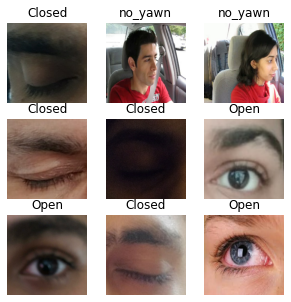

In [ ]:
class_names=train_ds.class_names
plt.figure(figsize=(5, 5))
for images ,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
aututune = tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=aututune)
val_ds=val_ds.cache().prefetch(buffer_size=aututune)
test_ds=test_ds.cache().prefetch(buffer_size=aututune)

In [ ]:
'''data_augmentation= tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),
    ]
)'''

'data_augmentation= tf.keras.Sequential(\n    [\n     tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),\n    ]\n)'

In [ ]:
'''image , label= next(iter(train_ds))
plt.figure(figsize=(5,5))
first_image=image[13]
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  augmented_image=data_augmentation(first_image)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis('off')'''

'image , label= next(iter(train_ds))\nplt.figure(figsize=(5,5))\nfirst_image=image[13]\nfor i in range(9):\n  ax=plt.subplot(3,3,i+1)\n  augmented_image=data_augmentation(first_image)\n  plt.imshow(augmented_image.numpy().astype("uint8"))\n  plt.axis(\'off\')'

In [ ]:
model_vgg=tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model_vgg.trainable=False

In [ ]:
inputs= tf.keras.Input(shape=(256,256,3))
#x=data_augmentation(inputs)
x=model_vgg(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(16,activation='elu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(32,activation='elu')(x)
x=tf.keras.layers.Dropout(0.3)(x)
outputs=tf.keras.layers.Dense(4,activation="softmax")(x)
new_model=tf.keras.Model(inputs,outputs)

In [ ]:
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                544   

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1)
checkpoint =  tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/tmp/checkpoint', save_weights_only=True,
    monitor='val_accuracy', mode='max',save_best_only=True
)
history=new_model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[callback,checkpoint])

Epoch 1/50
70/70 [==============================] - 1495s 21s/step - loss: 0.7048 - accuracy: 0.6884 - val_loss: 0.4012 - val_accuracy: 0.7846
Epoch 2/50
70/70 [==============================] - 1451s 21s/step - loss: 0.3736 - accuracy: 0.8361 - val_loss: 0.2557 - val_accuracy: 0.8862
Epoch 3/50
70/70 [==============================] - 1453s 21s/step - loss: 0.2620 - accuracy: 0.9000 - val_loss: 0.2205 - val_accuracy: 0.9024
Epoch 4/50
70/70 [==============================] - 1452s 21s/step - loss: 0.1802 - accuracy: 0.9365 - val_loss: 0.1523 - val_accuracy: 0.9390
Epoch 5/50
70/70 [==============================] - 1457s 21s/step - loss: 0.1336 - accuracy: 0.9581 - val_loss: 0.1570 - val_accuracy: 0.9350


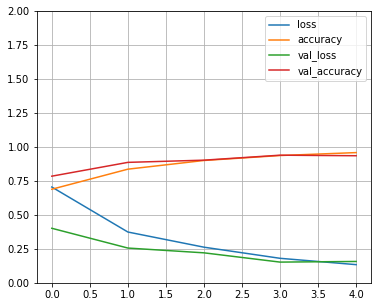

In [ ]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [ ]:
loss_t, acc_t= new_model.evaluate(test_ds)
print(acc_t)

14/14 [==============================] - 306s 18s/step - loss: 0.2139 - accuracy: 0.9145
0.9145496487617493


In [ ]:
loss_t

0.21393558382987976